# Introduction

This is a simple example usage of PHITS Tools.

In this example, `example_tproduct.inp` is the PHITS input file, and it features the [T-Product] tally, which scores what particles and nuclides are produced from particle interactions (in this case, nuclear interactions). [T-Product] is one of the three special tallies that can be used with the `dump` parameter to output an additional "dump" file of event-by-event data.

The `product.out` file is the standard tally output file, and `product.eps` is the visualized output file automatically produced by PHITS (which is made by a secondary program which processes the `*.out` file to create the `*.eps` file). The `product_dmp.out` file is the "dump" output file, with 11 columns of data in ASCII format (since the tally has set the parameter `dump = -11`).

In this notebook and in `example_PHITS_tools.py`, PHITS Tools is used to parse both the standard tally output file and the dump file. See the comments in the code to be stepped through instructions for what is being done. The `*.pickle` and `*.pickle.xz` files are produced by PHITS Tools, containing the numerical results and metadata extracted from the PHITS output files. The PNG file is a plot made using the PHITS Tools extracted output recreating the EPS file automatically produced by PHITS.

In [1]:
import PHITS_tools
from pathlib import Path
import pprint
import numpy as np
import matplotlib.pyplot as plt
import pickle
import lzma

In [2]:
# Set the filepaths
path_to_example_dir = Path.cwd() #Path('example/')
standard_output_file = Path(path_to_example_dir, 'product.out')
dump_output_file = Path(path_to_example_dir, 'product_dmp.out')

# Parsing a standard tally output file

Run the output file through the main parsing function in PHITS Tools. If you already have a pickle file from running PHITS Tools previously, you can skip re-parsing it and just load in the pickle file with the `prefer_reading_existing_pickle=True` setting.  If set to `True` but the pickle file doesn't exist, `parse_tally_output_file` will run just like normal, parse the output file and return the same dictionary object.  (You can also just load in the pickle file as one normally would.)  Setting `autoplot_tally_output=True` will cause PHITS Tools to automatically make a plot of the tally results and save it to product.pdf

In [3]:
results_dict = PHITS_tools.parse_tally_output_file(standard_output_file, 
                                                   prefer_reading_existing_pickle=False,
                                                   autoplot_tally_output=True)

Processing file: C:\test\phits\tools\example\product.out
	Pickle file written: C:\test\phits\tools\example\product.pickle
	Plot PDF written: C:\test\phits\tools\example\product.pdf


## Primary output dictionary
Let's take a look at the structure of the main outputted dictionary object.

In [4]:
print("keys of output dictionary:", results_dict.keys(), '\n')
tally_metadata = results_dict['tally_metadata']
tally_data = results_dict['tally_data']
tally_df = results_dict['tally_dataframe']

keys of output dictionary: dict_keys(['tally_data', 'tally_metadata', 'tally_dataframe']) 



## Metadata dictionary of standard tally output
Let's take a look at the structure of the outputted metadata dictionary.

In [5]:
pprint.pp(dict(tally_metadata))

{'tally_type': '[T-Product]',
 'PHITS-Tools_version': '1.6.0',
 'ne': 50,
 'nt': None,
 'nx': None,
 'ny': None,
 'nz': None,
 'nr': None,
 'na': None,
 'nl': None,
 'reg': 100,
 'part': 'all        neutron    proton     -( neutron  proton   )',
 'npart': 4,
 'nc': None,
 'axis': 'eng',
 'samepage': 'part',
 'title': 'Particle production in reg mesh',
 'mesh': 'reg',
 'reg_groups': ['100'],
 'num_reg_groups': 1,
 'e-type': 3,
 'emin': 1.0,
 'emax': 200.0,
 'edel': 0.1059663,
 'e-mesh_bin_edges': array([  1.     ,   1.11178,   1.23606,   1.37424,   1.52786,   1.69865,
         1.88853,   2.09964,   2.33434,   2.59529,   2.8854 ,   3.20794,
         3.56654,   3.96522,   4.40848,   4.90127,   5.44916,   6.05829,
         6.73551,   7.48844,   8.32553,   9.2562 ,  10.2909 ,  11.4413 ,
        12.7202 ,  14.1421 ,  15.723  ,  17.4806 ,  19.4347 ,  21.6071 ,
        24.0225 ,  26.7078 ,  29.6933 ,  33.0126 ,  36.7029 ,  40.8057 ,
        45.3672 ,  50.4385 ,  56.0767 ,  62.3453 ,  69.3145 ,

## Pandas DataFrame of standard tally output
The Pandas DataFrame is arranged in a way to contain the minimum necessary number of columns, with all values common to all rows instead written to `tally_df.attrs` instead.

In [6]:
print('Pandas DataFrame column headers and attributes:')
print(tally_df.columns.values.tolist())
print(tally_df.attrs)
print('Number of rows = ', tally_df.shape[0])
print(tally_df.to_string())   # uncomment to print the whole dataframe (200 lines)

Pandas DataFrame column headers and attributes:
['ir', 'reg', 'reg#', 'ie', 'e_mid', 'ip', 'particle', 'kf-code', 'value', 'rel.err.', 'abs.err.']
{'Time': 'default/all', 'Angle': 'default/all', 'LET': 'default/all'}
Number of rows =  200
     ir  reg reg#  ie       e_mid  ip           particle       kf-code     value  rel.err.  abs.err.
0     0  100  100   0    1.055890   0                all             0  0.011483    0.0991  0.001138
1     0  100  100   0    1.055890   1            neutron          2112  0.002083    0.2478  0.000516
2     0  100  100   0    1.055890   2             proton          2212  0.001100    0.3276  0.000360
3     0  100  100   0    1.055890   3  -(neutron proton)  -(2112 2212)  0.008300    0.1106  0.000918
4     0  100  100   1    1.173920   0                all             0  0.008289    0.1145  0.000949
5     0  100  100   1    1.173920   1            neutron          2112  0.000989    0.3471  0.000343
6     0  100  100   1    1.173920   2             prot

## NumPy array of standard tally output
Note that the array is accessed as `tally_data[ ir, iy, iz, ie, it, ia, il, ip, ic, ierr ]`, with indices/axes explained below:

- `0` | `ir`, Geometry mesh: `reg` / `x` / `r` / `tet` ([T-Cross] `ir surf` if `mesh=r-z` with `enclos=0`)
- `1` | `iy`, Geometry mesh:  `1` / `y` / `1`
- `2` | `iz`, Geometry mesh:  `1` / `z` / `z` ([T-Cross] `iz surf` if `mesh=xyz` or `mesh=r-z` with `enclos=0`)
- `3` | `ie`, Energy mesh: `eng` ([T-Deposit2] `eng1`)
- `4` | `it`, Time mesh
- `5` | `ia`, Angle mesh
- `6` | `il`, LET mesh
- `7` | `ip`, Particle type (`part = `)
- `8` | `ic`, Special: [T-Deposit2] `eng2`; [T-Yield] `mass`, `charge`, `chart`; [T-Interact] `act`
- `9` | `ierr = 0/1/2`, Value / relative uncertainty / absolute uncertainty (expanded to `3/4/5`, or `2/3` if `calculate_absolute_errors = False`, for [T-Cross] `mesh=r-z` with `enclos=0` case; see notes in full documentation)

In [7]:
np_array_dims = np.shape(tally_data)
print('NumPy array dimensions:', np_array_dims, '\n')

NumPy array dimensions: (1, 1, 1, 50, 1, 1, 1, 4, 1, 3) 



## Recreating the `.eps` automatic PHITS output
Using PHITS Tools, let's recreate the below `.eps` plot that was automatically produced by PHITS from the `product.out` file.

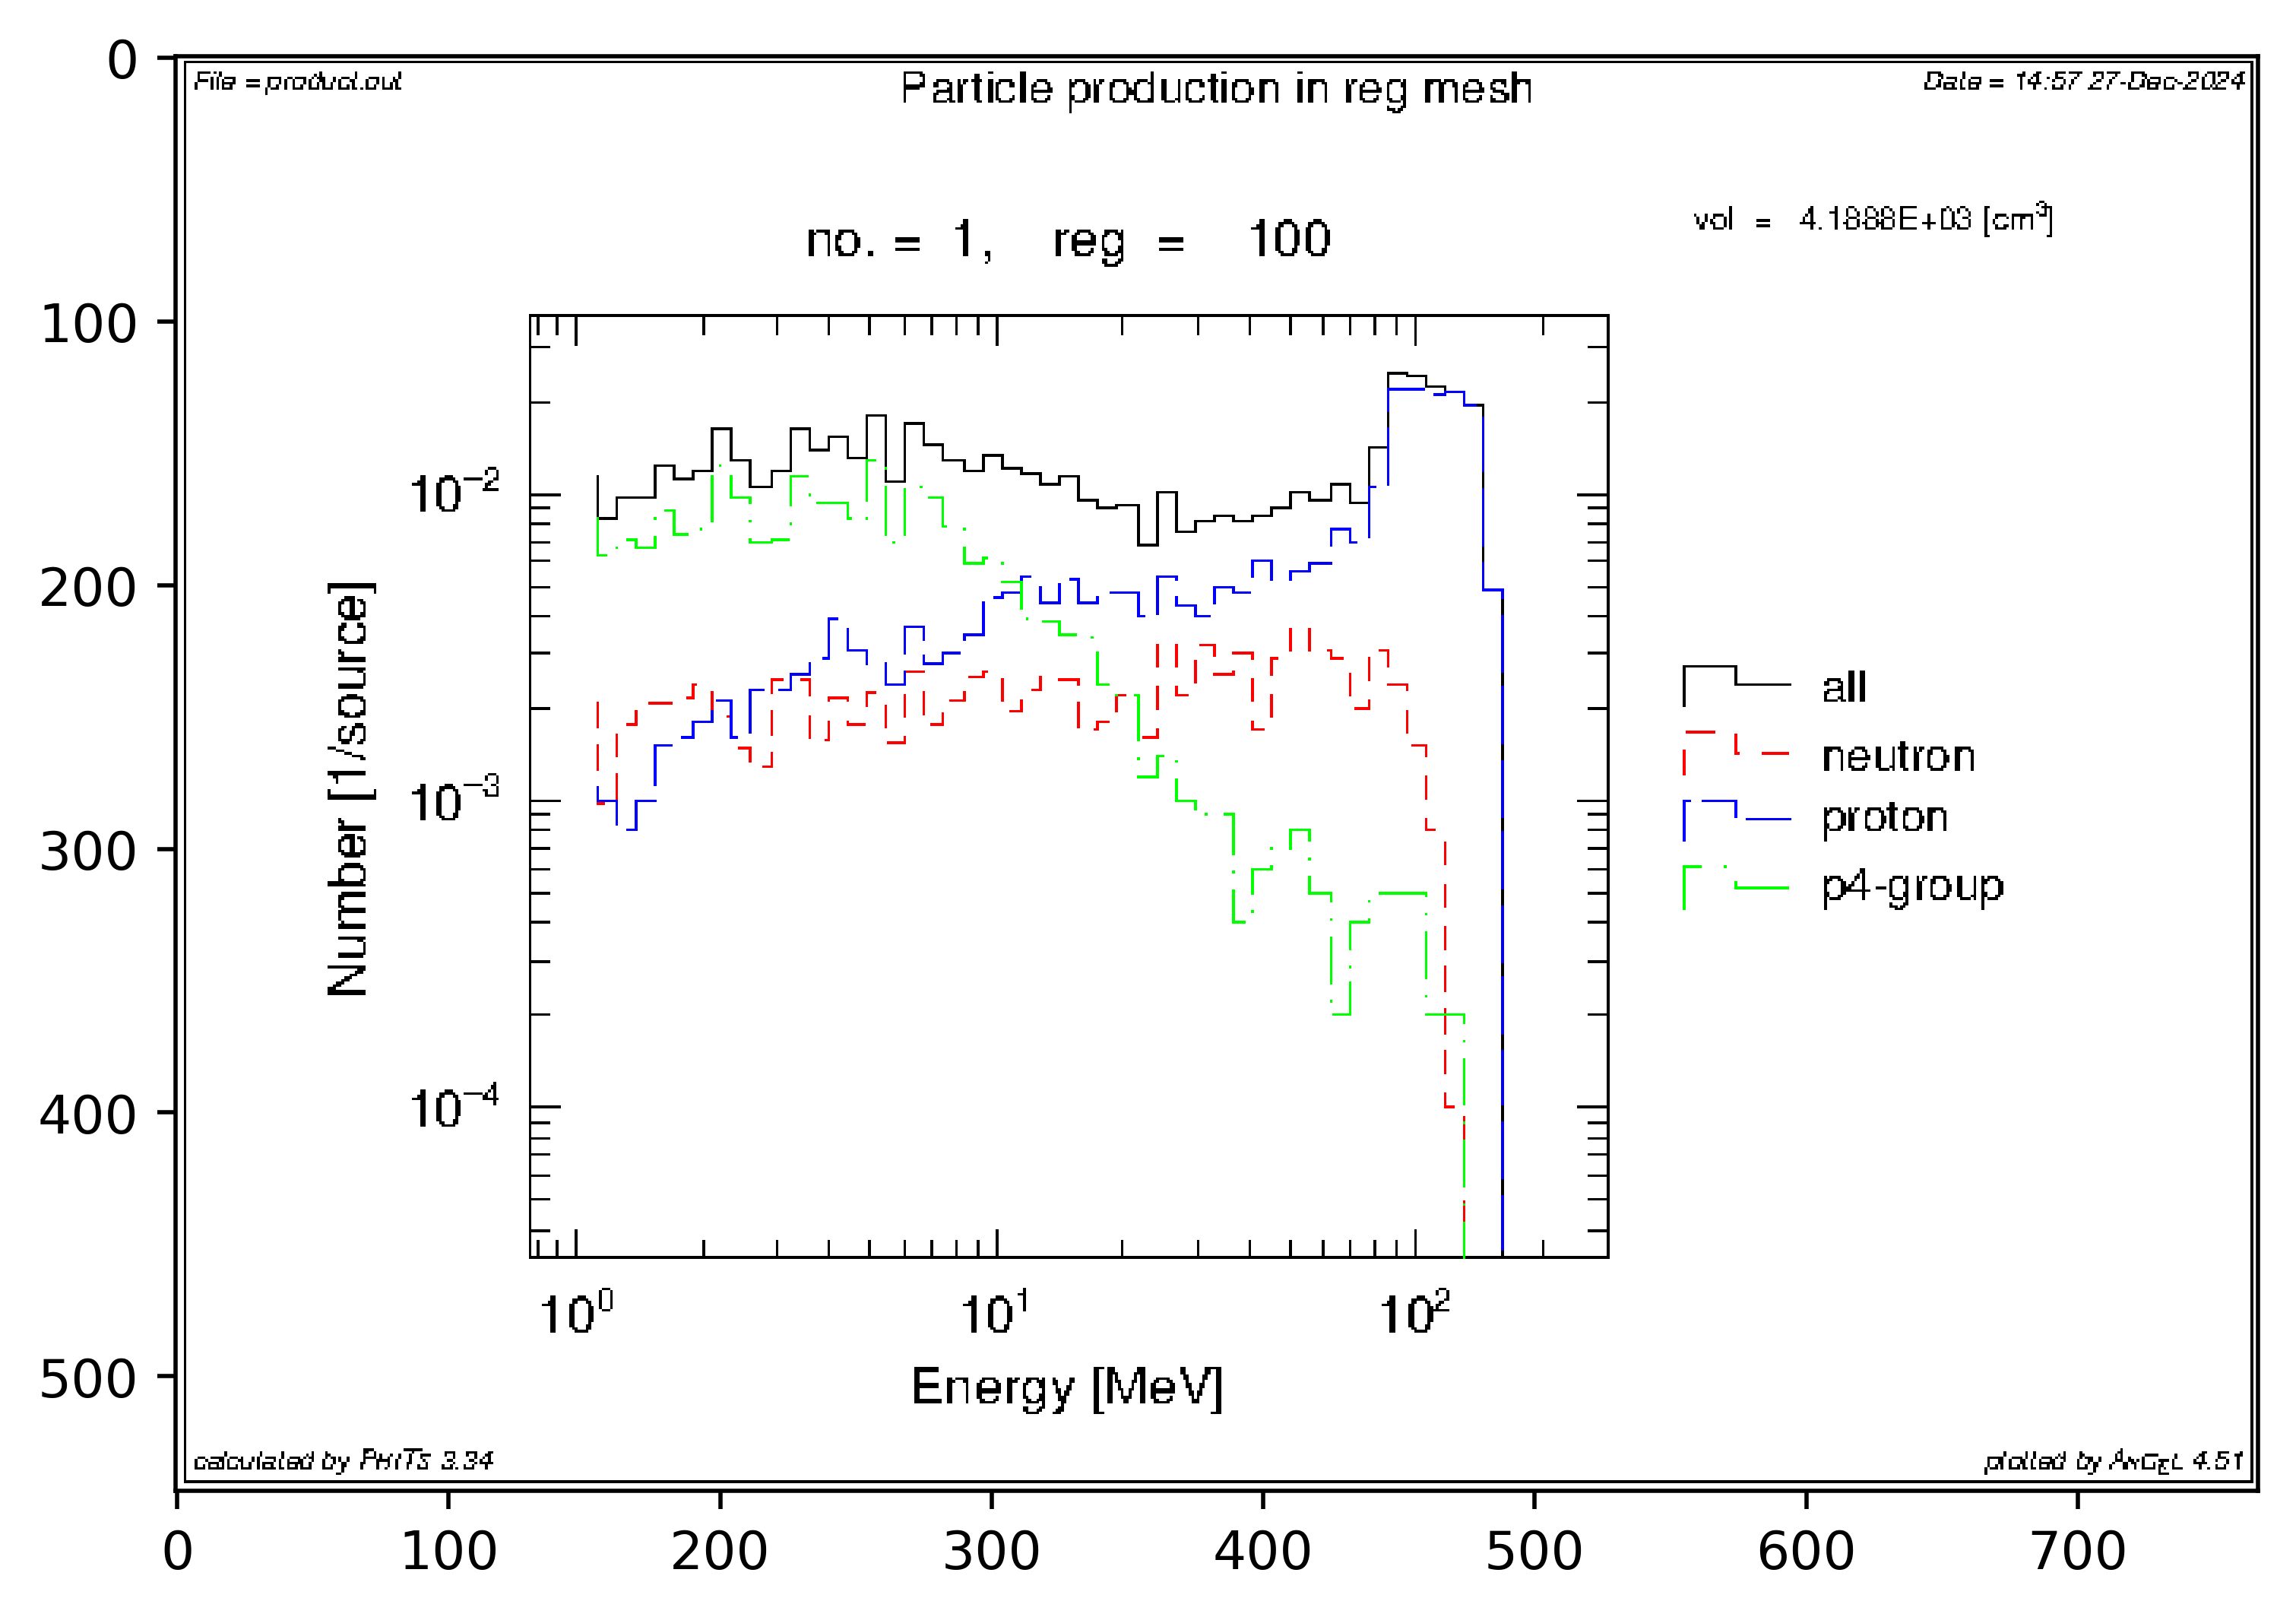

In [8]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
ar = 1.41421
size = 5
fig, ax = plt.subplots(figsize=(ar*size,size), dpi=500)
image = mpimg.imread('product.eps')
image_arr = np.array(image)
image_arr = np.rot90(image_arr, axes=(1,0))
plt.imshow(image_arr, aspect="auto", interpolation="none")
plt.show()

Now recreating the plot using the `tally_data` array...

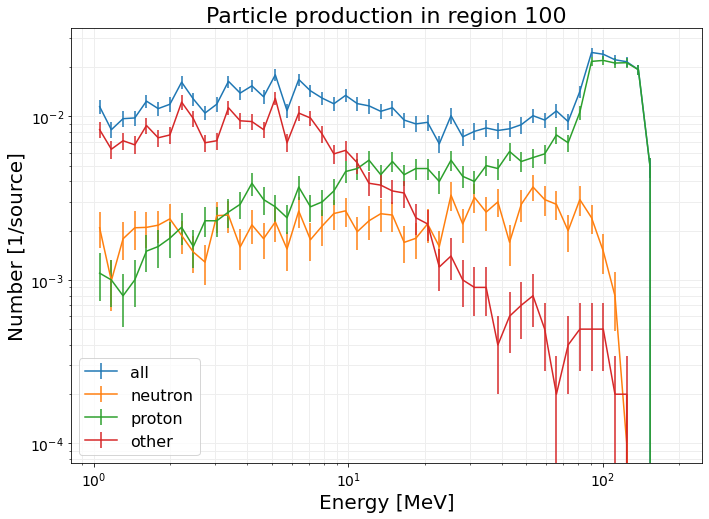

In [9]:
energy_bin_midpoints = tally_metadata['e-mesh_bin_mids_log']  # in units of MeV
# the "e-type = 3" setting means energy bins are log-spaced, so using the log-centered bin midpoints makes the most sense here
particle_group_labels = tally_metadata['part_groups']
particle_group_labels[-1] = 'other'  # rename the "not neutrons and not protons" group to just "other"
size=8
plt.figure(figsize=(ar*size,size))
# Nominal way to access `tally_data` array
# for ip in range(np_array_dims[7]):
#     plt.errorbar(energy_bin_midpoints, tally_data[0,0,0,:,0,0,0,ip,0,0], yerr=tally_data[0,0,0,:,0,0,0,ip,0,2])
# Made easier with the `PHITS_tools.tally_data_indices()` function:
for particle_name in tally_metadata['part_groups']:
    data_indices = PHITS_tools.tally_data_indices(ie='all', part=particle_name, ival=0, default_to_all=False, tally_metadata=tally_metadata)
    error_indices = PHITS_tools.tally_data_indices(ie='all', part=particle_name, ival=2, default_to_all=False, tally_metadata=tally_metadata)
    plt.errorbar(energy_bin_midpoints, tally_data[data_indices], yerr=tally_data[error_indices])
plt.legend(particle_group_labels, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy [MeV]', size=20)
plt.ylabel('Number [1/source]', size=20)
plt.title('Particle production in region 100', size=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(which='both', linewidth=1, color='#EEEEEE')
fig_path = Path(path_to_example_dir,'production_energy_spectrum_by_particle.png')
plt.savefig(fig_path)
plt.show()

Also, because we ran `PHITS_tools.parse_tally_output_file()` earlier with the setting `autoplot_tally_output=True`, a plot of the tally's output was generated and saved automatically with the name product.pdf/.png (same as the PHITS output file, but with the extension changed to .pdf/.png), shown below.

![](product.png)

In [10]:
from IPython.display import IFrame
IFrame("product.pdf", width=900, height=550)

While in this circumstance the PHITS Tools automatically generated plot is formatted very similarly to the .eps file plot, note that this is not always guaranteed. 

If we want to further customize this plot, we can directly use the PHITS Tools function for generating plots automatically and have it return the seaborn FacetGrid objects with the `return_fg_list=True` setting, allowing for further customization.

	Plot PDF written: C:\test\phits\tools\example\product_customized.pdf


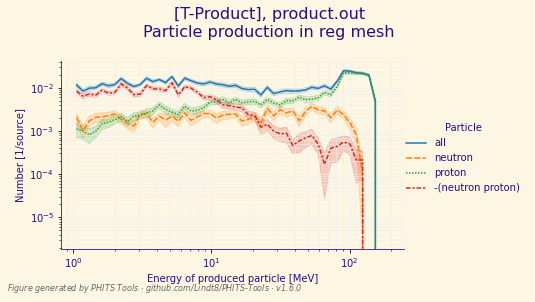

In [11]:
customized_autoplot_pdf = Path(path_to_example_dir, 'product_customized.pdf')
fg_list = PHITS_tools.autoplot_tally_results(results_dict, output_filename=customized_autoplot_pdf, return_fg_list=True)
text_color, background_color = '#260F80', '#FCF6E3'
fg_list[0].fig.set_facecolor(background_color)  # change background color of figure exterior
fg_list[0].ax.set_facecolor(background_color)  # change background color of plot area
fg_list[0].ax.tick_params(labelcolor=text_color)  # change font color of axis tick labels (the numbers)
for spine in fg_list[0].ax.spines.values(): spine.set_edgecolor(text_color)  # change color of axes and ticks
fg_list[0].fig._suptitle.set_color(text_color)  # change font color of title
fg_list[0]._legend.get_title().set(color=text_color)  # change font color of legend title
for text in fg_list[0]._legend.get_texts(): text.set(color=text_color)  # change font color of text entries in legend
fg_list[0].ax.set_xlabel('Energy of produced particle [MeV]', color=text_color)  # change x-axis label text and color
fg_list[0].ax.set_ylabel(fg_list[0].ax.get_ylabel(), color=text_color)  # change y-axis label color only
fg_list[0].savefig(customized_autoplot_pdf)  # save the new customized plot
plt.show()

# Parsing a tally dump output file
Now let's explore processing a tally dump output file with PHITS Tools.

Given parsing dump files can take a bit longer owing to their size, I think it's generally preferable to only parse the dump file once and then just load in the saved dill/pickle file(s) afterward, as is shown below.

In [12]:
named_tuple_dill_file = Path(dump_output_file.parent, dump_output_file.stem + '_namedtuple_list.dill.xz')
dump_dataframe_file = Path(dump_output_file.parent, dump_output_file.stem + '_Pandas_df.pickle.xz')
if named_tuple_dill_file.is_file() and dump_dataframe_file.is_file():
    with lzma.open(named_tuple_dill_file, 'rb') as file: events_list = pickle.load(file)
    with lzma.open(dump_dataframe_file, 'rb') as file: events_df = pickle.load(file)
else:
    events_list, events_df = PHITS_tools.parse_tally_dump_file(dump_output_file, save_namedtuple_list=True, save_Pandas_dataframe=True)

Processing file: C:\test\phits\tools\example\product_dmp.out
	Pickle file written: C:\test\phits\tools\example\product_dmp_namedtuple_list.pickle.xz
	Pickle file written: C:\test\phits\tools\example\product_dmp_Pandas_df.pickle.xz


This file has 11 columns of data for every single history that contributed to the tally.  The first 25 rows are printed below.

In [13]:
print('Pandas DataFrame column headers for dump file:')
print(events_df.columns.values.tolist())
print('Number of rows (one per tallied event) = ', events_df.shape[0])
print('The Pandas DataFrame itself (first 25 rows):')
print(events_df.head(25).to_string())
# print(events_df.to_string())   # uncomment to print the whole dataframe

Pandas DataFrame column headers for dump file:
['kf', 'x', 'y', 'z', 'e', 'time', 'wt', 'name', 'nocas', 'nobch', 'no']
Number of rows (one per tallied event) =  5958
The Pandas DataFrame itself (first 25 rows):
           kf         x         y         z           e      time   wt  name  nocas  nobch   no
0      2212.0  0.000000  0.000000  7.346421  104.015459  0.516670  1.0   1.0   13.0    1.0  1.0
1      2112.0  0.000000  0.000000  5.429238   67.445803  0.374168  1.0   1.0   17.0    1.0  1.0
2      2212.0  0.000000  0.000000  5.429238    8.922260  0.374168  1.0   1.0   17.0    1.0  1.0
3      2212.0  0.000000  0.000000  5.429238   13.881980  0.374168  1.0   1.0   17.0    1.0  1.0
4   7000014.0  0.000000  0.000000  5.429238    0.114750  0.374168  1.0   1.0   17.0    1.0  1.0
5        22.0  0.000000  0.000000  5.429238    3.139511  0.374168  1.0   1.0   17.0    1.0  1.0
6      2212.0  0.000000  0.000000  0.641302  146.066686  0.042424  1.0   1.0   19.0    1.0  1.0
7      2212.0  0.000

As an exercise, now let's compile a list of all the unique product nuclides produced, telling us what's in that "other" category.

In [14]:
found_kf_codes = []
for i in events_list:
    if i.kf not in found_kf_codes:
        found_kf_codes.append(int(i.kf))
found_kf_codes.sort()
# print(found_kf_codes)
# Let's make a human-readable list
# the kf-code table can be found in Table 4.4 of the PHITS manual
found_products = []
for i in found_kf_codes:
    found_products.append(PHITS_tools.kfcode_to_common_name(i))
print('The following particles and nuclides were produced:')
print(found_products)

The following particles and nuclides were produced:
['photon', 'neutron', 'proton', 'H-2', 'H-3', 'He-3', 'He-4', 'Li-6', 'Li-7', 'Be-6', 'Be-7', 'Be-9', 'B-10', 'B-11', 'C-10', 'C-11', 'C-12', 'C-13', 'C-14', 'N-13', 'N-14', 'N-15', 'O-13', 'O-14', 'O-15', 'O-16']


# Other functions in PHITS Tools

The `PHITS_tools` module also contains a number of other useful functions for various analyses, as detailed in the [PHITS Tools documentation](https://lindt8.github.io/PHITS-Tools/). 

For example, we can use the [`tally()`](https://hratliff.com/PHITS-Tools/#PHITS_tools.tally) function to make our own tally over the dump file's contents.  While the [T-Yield] tally in PHITS is designed for scoring residual nuclides, it does not (at time of writing) support the `dump` feature, meaning if you wanted to perform some complex conditional scoring on produced nuclides, creating your own tally over a [T-Product] dump file would be the way to achieve this.  Owing to all the extra scoring options within [T-Yield], this situation is likely to be quite uncommon, but the point here is to just demonstrate this custom tally idea.

In this case, let's make a tally of the charge spectra for produced nuclides (so, excluding neutrons and photons) spanwed in the 0.3 to 0.5 ns time window and with kinetic energy between 0 and 10 MeV/u.  (Again, this is something a stock tally could do, but it demos this more advanced custom filtering + tallying idea.)




In [15]:
# Make a list of nucleus charges for events satisfying our filter criteria
Z_list = []
for i in events_list:
    if i.time < 0.3 or i.time > 0.5: 
        continue
    if i.e > 10:
        continue
    nucleus_str = PHITS_tools.kfcode_to_common_name(int(i.kf))
    if nucleus_str in ['neutron', 'photon']: 
        continue
    elif nucleus_str == 'proton':
        Z = 1
    else:
        element = nucleus_str.split('-')[0]
        Z = PHITS_tools.element_symbol_to_Z(element)
    Z_list.append(Z)
    
# Now tally our list of Z values
tallied_hist, bin_edges, tallied_hist_err = PHITS_tools.tally(Z_list,
                                                             min_bin_left_edge=1,
                                                             max_bin_right_edge=9,
                                                             bin_width=1,
                                                             return_uncertainties=True)
print('bin edges:',bin_edges)
print('tallied histogram:', tallied_hist)
print('absolute errors:', tallied_hist_err)

bin edges: [1 2 3 4 5 6 7 8 9]
tallied histogram: [182 168   6   5   5  45  50  50]
absolute errors: [13.49073756 12.9614814   2.44948974  2.23606798  2.23606798  6.70820393
  7.07106781  7.07106781]


Let's make a simple plot of this.

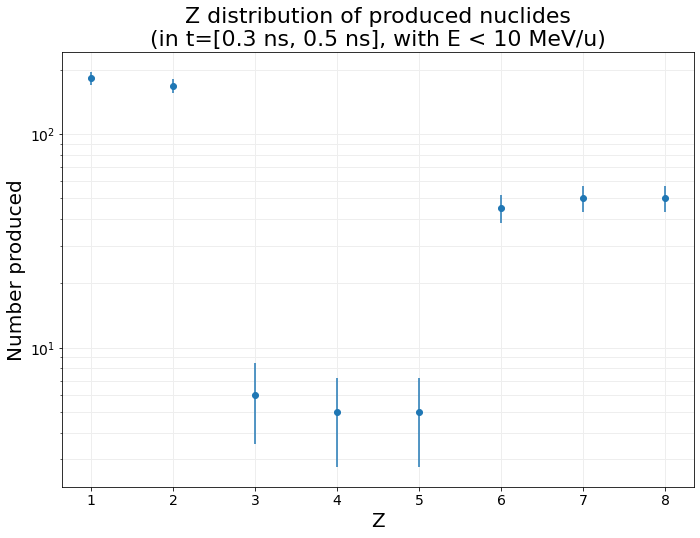

In [16]:
size=8
plt.figure(figsize=(ar*size,size))
plt.errorbar(bin_edges[:-1], tallied_hist, yerr=tallied_hist_err, ls='', marker='o')
plt.yscale('log')
plt.xlabel('Z', size=20)
plt.ylabel('Number produced', size=20)
plt.title('Z distribution of produced nuclides\n(in t=[0.3 ns, 0.5 ns], with E < 10 MeV/u)', size=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(which='both', linewidth=1, color='#EEEEEE')
plt.show()